# Assignment 8: DT

<h2>Data splitting and pre-processing</h2>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle
from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter



In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [4]:
#filling 3 null teacher prefix values with Teacher

project_data["teacher_prefix"].fillna("Teacher",inplace = True)
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [5]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [6]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [7]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 20 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109248 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

In [8]:
#splitting data as 30% to test
y = project_data["project_is_approved"]
X = project_data.drop("project_is_approved",axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
print(X_train.shape," ",y_train.shape)
print(X_test.shape," ",y_test.shape)

(76473, 19)   (76473,)
(32775, 19)   (32775,)


<h3>Preprocessing categorical Features</h3>

1. project subject categories

In [10]:
#using code from assignment
# project subject categories
catogories = list(X_train['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_train['clean_categories'] = cat_list
X_train.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


# project subject categories for test data

catogories = list(X_test['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_test['clean_categories'] = cat_list
X_test.drop(['project_subject_categories'], axis=1, inplace=True)


2. project subject sub_categories

In [11]:
sub_catogories = list(X_train['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_train['clean_subcategories'] = sub_cat_list
X_train.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


sub_catogories = list(X_test['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_test['clean_subcategories'] = sub_cat_list
X_test.drop(['project_subject_subcategories'], axis=1, inplace=True)

3. Teacher Prefix

In [12]:
#preprocessing teacher prefix
prefix = list(X_train['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_train['clean_prefix'] = prefix_list

my_counter = Counter()
for word in X_train['clean_prefix'].values:
  my_counter.update(word.split())

prefix_dict = dict(my_counter)
sorted_prefix_dict = dict(sorted(prefix_dict.items(), key=lambda kv: kv[1]))
print(sorted_prefix_dict)


#preprocessing teacher prefix for test data
prefix = list(X_test['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_test['clean_prefix'] = prefix_list



{'Dr': 9, 'Teacher': 1647, 'Mr': 7457, 'Ms': 27320, 'Mrs': 40040}


4. Project Grade Category

In [13]:
# preprocessing of grade category for train data

grade = list(X_train['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_train['clean_grade'] = grade_list

my_counter = Counter()
for word in X_train['clean_grade'].values:
  my_counter.update(word.split())

grade_dict = dict(my_counter)
sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print(sorted_grade_dict)

# preprocessing of grade category for test data

grade = list(X_test['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_test['clean_grade'] = grade_list


{'nine_twelve': 7670, 'six_eight': 11843, 'three_five': 25958, 'prek_two': 31002}


5. School State

In [14]:
#no need of preprocessing on school state

state = X_train["school_state"].value_counts()
sorted_state = dict(state)
sorted_state_dict = dict(sorted(sorted_state.items(), key=lambda kv: kv[1]))
X_train["clean_state"] = X_train["school_state"]

#similarly for X_test
X_test["clean_state"] = X_test["school_state"]

<h3>Preprocessing Numerical Feature</h3>

1. Standardizing price

In [15]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data price standardization
price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))

#test data price stanardization. Fit method applied on X_train
test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


2. Standardizing quantity

In [16]:
price_scalar = StandardScaler()
price_scalar.fit(X_train["quantity"].values.reshape(-1, 1))
print(f"Mean of Quantity : {price_scalar.mean_[0]}, Standard deviation of Quantity : {np.sqrt(price_scalar.var_[0])}")

#train data quantity standardization
quantity_standardized = price_scalar.transform(X_train["quantity"].values.reshape(-1, 1))

#test data quantity stanardization. Fit method applied on X_train
test_quantity_standardized = price_scalar.transform(X_test["quantity"].values.reshape(-1, 1))

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean of Quantity : 16.951629987054254, Standard deviation of Quantity : 25.894395919389655


C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



3. Standardizing number of ppp

In [17]:
price_scalar = StandardScaler()
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data ppp standardization
number_ppp_standardized = price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#test data price stanardization. Fit method applied on X_train
test_number_ppp_standardized = price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 11.09995684751481, Standard deviation : 27.56154092526415


C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



<h3>Preprocessing of Text Feature for both test and train data</h3>

In [18]:
#using function and stopwords form assignemnt

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

1. preprocessing of project essay

In [19]:
from tqdm import tqdm

#for train data
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
    
test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_essays.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 32775/32775 [00:20<00:00, 1631.02it/s]


2. preprocessing of project title

In [20]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
    
# for test data
test_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_title.append(sent.lower().strip())


100%|█████████████████████████████████████████████████████████████████████████| 32775/32775 [00:00<00:00, 36798.19it/s]


<h3>Vectorizing of Categorical data</h3>

1. Vectorizing project categories and subcategories

In [21]:
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())
categories_feature = vectorizer.get_feature_names()

# for train data
categories_one_hot = vectorizer.transform(X_train['clean_categories'].values)

print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

# for test data
test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (76473, 9)


2. Vectorizing project subcategories

In [22]:
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())
subcategories_feature = vectorizer.get_feature_names()

# for train data
sub_categories_one_hot = vectorizer.transform(X_train['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

# for test data
test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'Gym_Fitness', 'ESL', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (76473, 30)


3. vectorizing teacher prefix

In [23]:
vectorizer = CountVectorizer(vocabulary=list(prefix_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())
prefix_feature = vectorizer.get_feature_names()
# for train data
prefix_one_hot = vectorizer.transform(X_train['clean_prefix'].values)
print("Shape of matrix after one hot encodig ",prefix_one_hot.shape)

# for test data
test_prefix_one_hot = vectorizer.transform(X_test['clean_prefix'].values)

['Ms', 'Mrs', 'Mr', 'Teacher', 'Dr']
Shape of matrix after one hot encodig  (76473, 5)


4. Vectorizing school state and grade

In [24]:
vectorizer = CountVectorizer(vocabulary=list(grade_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_grade'].values)
print(vectorizer.get_feature_names())
grade_feature = vectorizer.get_feature_names()
# for train data
grade_one_hot = vectorizer.transform(X_train['clean_grade'].values)
print("Shape of matrix after one hot encodig ",grade_one_hot.shape)

# for test data
test_grade_one_hot = vectorizer.transform(X_test['clean_grade'].values)


vectorizer = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_state'].values)
print(vectorizer.get_feature_names())
state_one_hot = vectorizer.transform(X_train['clean_state'].values)
state_feature = vectorizer.get_feature_names()
test_state_one_hot = vectorizer.transform(X_test['clean_state'].values)



['prek_two', 'nine_twelve', 'three_five', 'six_eight']
Shape of matrix after one hot encodig  (76473, 4)
['VT', 'WY', 'ND', 'MT', 'RI', 'NE', 'SD', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'KY', 'OR', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'OK', 'NJ', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


<h3>Vectorizing Text Feature</h3>

1. BOW

In [25]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
#fit using train data
vectorizer.fit(preprocessed_essays)
essay_feature = vectorizer.get_feature_names()


# for train data
text_bow = vectorizer.transform(preprocessed_essays)
print("Shape of train matrix : ",text_bow.shape)
# for test data
test_text_bow = vectorizer.transform(test_preprocessed_essays)
print("Shape of test matrix : ",test_text_bow.shape)


# for title
vectorizer.fit(preprocessed_title)
title_feature = vectorizer.get_feature_names()

# for train data
title_bow = vectorizer.transform(preprocessed_title)
print("Shape of train matrix : ",title_bow.shape)
# for test data
test_title_bow = vectorizer.transform(test_preprocessed_title)
print("Shape of test matrix : ",test_title_bow.shape)

Shape of train matrix :  (76473, 5000)
Shape of test matrix :  (32775, 5000)
Shape of train matrix :  (76473, 2843)
Shape of test matrix :  (32775, 2843)


2. TFIDF

In [26]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
#fit using train data
vectorizer.fit(preprocessed_essays)
essay_feature_tfidf = vectorizer.get_feature_names()
# for train data
text_tfidf = vectorizer.transform(preprocessed_essays)
print("Shape of train matrix : ",text_tfidf.shape)
# for test data
test_text_tfidf = vectorizer.transform(test_preprocessed_essays)
print("Shape of test matrix : ",test_text_tfidf.shape)


# for title
vectorizer.fit(preprocessed_title)
title_feature_tfidf = vectorizer.get_feature_names()

# for train data
title_tfidf = vectorizer.transform(preprocessed_title)
print("Shape of train matrix : ",title_tfidf.shape)
# for test data
test_title_tfidf = vectorizer.transform(test_preprocessed_title)
print("Shape of test matrix : ",test_title_tfidf.shape)

Shape of train matrix :  (76473, 5000)
Shape of test matrix :  (32775, 5000)
Shape of train matrix :  (76473, 2843)
Shape of test matrix :  (32775, 2843)


3. Avg W2v

In [27]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [28]:
# for train data
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))
    
# for test data
test_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_vectors.append(vector)

print(len(test_avg_w2v_vectors))
print(len(test_avg_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 76473/76473 [00:23<00:00, 3207.10it/s]


76473
300


100%|██████████████████████████████████████████████████████████████████████████| 32775/32775 [00:09<00:00, 3318.82it/s]


32775
300


In [29]:
title_avg_w2v_vectors = []
for sentence in tqdm(preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors.append(vector)

print(len(title_avg_w2v_vectors))
print(len(title_avg_w2v_vectors[0]))

# for test data
test_title_avg_w2v_vectors = []
for sentence in tqdm(test_preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_title_avg_w2v_vectors.append(vector)

print(len(test_title_avg_w2v_vectors))
print(len(test_title_avg_w2v_vectors[0]))


100%|█████████████████████████████████████████████████████████████████████████| 76473/76473 [00:01<00:00, 65253.80it/s]


76473
300


100%|█████████████████████████████████████████████████████████████████████████| 32775/32775 [00:00<00:00, 65546.84it/s]


32775
300


4. TFIDF avgw2v

In [30]:
test_tfidf_model = TfidfVectorizer()
test_tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(test_tfidf_model.get_feature_names(), list(test_tfidf_model.idf_)))
tfidf_words = set(test_tfidf_model.get_feature_names())

test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))


# for title 
test_tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(test_tfidf_model.get_feature_names(), list(test_tfidf_model.idf_)))
tfidf_words = set(test_tfidf_model.get_feature_names())


test_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v_vectors.append(vector)

print(len(test_title_tfidf_w2v_vectors))


100%|███████████████████████████████████████████████████████████████████████████| 32775/32775 [01:09<00:00, 474.12it/s]


32775
300


100%|█████████████████████████████████████████████████████████████████████████| 32775/32775 [00:01<00:00, 31780.25it/s]


32775


In [31]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

# for title 
tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors.append(vector)

print(len(title_tfidf_w2v_vectors))

100%|███████████████████████████████████████████████████████████████████████████| 76473/76473 [02:44<00:00, 464.23it/s]


76473
300


100%|█████████████████████████████████████████████████████████████████████████| 76473/76473 [00:02<00:00, 32840.60it/s]


76473


Printing all

In [32]:
print("*"*70)
print("Categorical Features that are considered :- ")
print("Subject Categories :- ",categories_one_hot.shape)
print("Subject Sub-Categories :- ",sub_categories_one_hot.shape)
print("Sudent Grade :- ",grade_one_hot.shape)
print("School State :- ",state_one_hot.shape)
print("Teacher Prefix :- ",prefix_one_hot.shape)
print("*"*70)

**********************************************************************
Categorical Features that are considered :- 
Subject Categories :-  (76473, 9)
Subject Sub-Categories :-  (76473, 30)
Sudent Grade :-  (76473, 4)
School State :-  (76473, 51)
Teacher Prefix :-  (76473, 5)
**********************************************************************


In [33]:
print("Text Features that are considered :- ")
print("*"*70)
print("Project Essay BOW:- ",text_bow.shape)
print("Project Essay TFIDF:- ",text_tfidf.shape)
print("*"*70)
print("Project Title BOW:- ",title_bow.shape)
print("Project Title TFIDF:- ",title_tfidf.shape)
print("*"*70)

Text Features that are considered :- 
**********************************************************************
Project Essay BOW:-  (76473, 5000)
Project Essay TFIDF:-  (76473, 5000)
**********************************************************************
Project Title BOW:-  (76473, 2843)
Project Title TFIDF:-  (76473, 2843)
**********************************************************************


# sets

In [34]:
#combining all feature into one
from scipy.sparse import hstack

set1 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,grade_one_hot,state_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,text_bow,title_bow))
set1_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_grade_one_hot,test_state_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_text_bow,test_title_bow))

set2 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,text_tfidf,title_tfidf,price_standardized,quantity_standardized,number_ppp_standardized))
set2_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_state_one_hot,test_grade_one_hot,test_text_tfidf,test_title_tfidf,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized))

set3 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,avg_w2v_vectors,title_avg_w2v_vectors))
set3_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_state_one_hot,test_grade_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_avg_w2v_vectors,test_title_avg_w2v_vectors))

set4 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,tfidf_w2v_vectors,title_tfidf_w2v_vectors))
set4_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_state_one_hot,test_grade_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_tfidf_w2v_vectors,test_title_tfidf_w2v_vectors))


print(set1.shape,"\t",set1_t.shape)
print(set2.shape,"\t",set2_t.shape)
print(set3.shape,"\t",set3_t.shape)
print(set4.shape,"\t",set4_t.shape)

(76473, 7945) 	 (32775, 7945)
(76473, 7945) 	 (32775, 7945)
(76473, 702) 	 (32775, 702)
(76473, 702) 	 (32775, 702)


In [35]:
set_feature = categories_feature + subcategories_feature + prefix_feature + grade_feature + state_feature + essay_feature_tfidf + title_feature_tfidf


set_feature.append("price")
set_feature.append("quantity")
set_feature.append("number")
print(len(set_feature))

7945


In [36]:
param_grid = dict(max_depth =  [1, 5, 10, 50, 100],min_samples_split = [5, 10, 100, 500])

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from wordcloud import WordCloud, STOPWORDS 

In [38]:
def Plot_wordcloud(words):
    
    """
     Function for plotting wordcloud.
    """
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
                          min_font_size = 10).generate(words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (8,8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title("Word Cloud Plot")
    plt.show()

## SET1 (BOW)

In [39]:
dt = DecisionTreeClassifier(class_weight="balanced")
grid = GridSearchCV(dt,param_grid,scoring="roc_auc",n_jobs=-1,cv=5)

In [40]:
grid.fit(set1,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
print(grid.best_estimator_)
print(grid.best_index_)
print(grid.best_params_)
print(grid.best_score_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
11
{'max_depth': 10, 'min_samples_split': 500}
0.6681821280481608


In [42]:
#converting results to dataframe
df = pd.DataFrame(data = grid.cv_results_)

# getting into list
test_score = df["mean_test_score"].values
train_score = df["mean_train_score"].values
  
print(train_score)
print(test_score )
x = [x for x in range(len(train_score))]

[0.56693703 0.56693703 0.56693703 0.56693703 0.66702357 0.66701203
 0.66697084 0.66645287 0.73158669 0.72947075 0.72138965 0.70848536
 0.9451549  0.9311776  0.88062534 0.82158576 0.97770452 0.96686282
 0.92477879 0.85938519]
[0.5669371  0.5669371  0.5669371  0.5669371  0.65757361 0.65754284
 0.6576046  0.65786183 0.66373117 0.66280685 0.66280987 0.66818213
 0.58852843 0.5900843  0.61042426 0.63068171 0.57820474 0.57767793
 0.59724568 0.61306057]


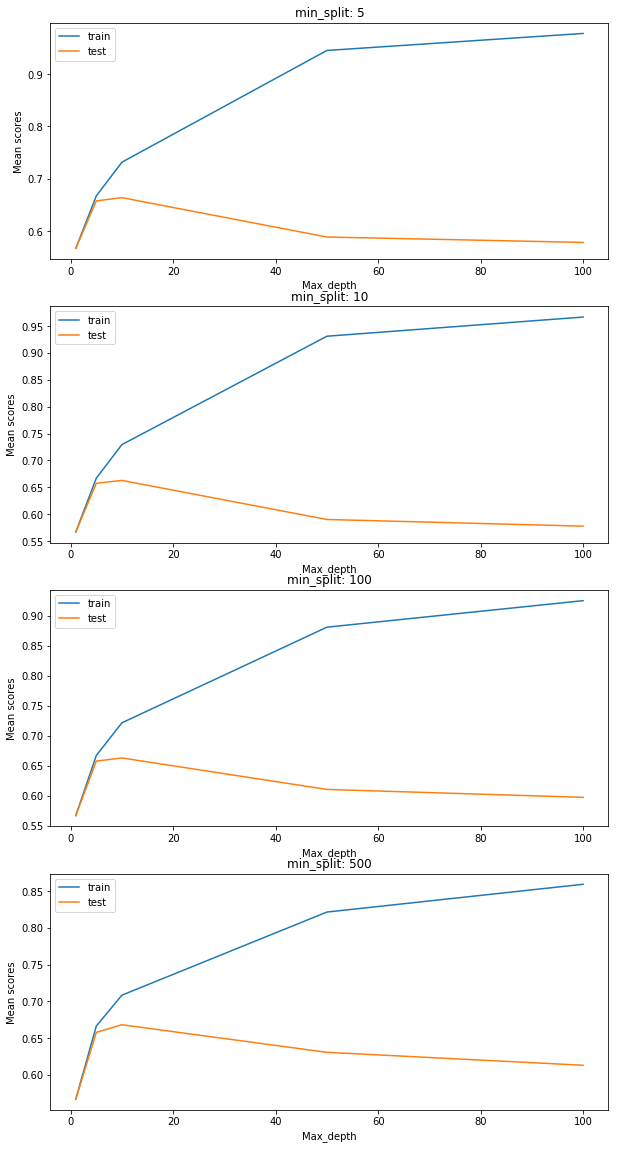

In [43]:
max_depth = [1, 5, 10, 50, 100]
plt.figure(figsize=(10,20))
for i,ms in enumerate(param_grid["min_samples_split"]):
    temp = [x for x in range(i,(16)+i+1,4)]
    train = [train_score[x] for x in temp]
    test = [test_score[x] for x in temp]
    plt.subplot(4,1,i+1)
    plt.title("min_split: "+str(ms))
    plt.plot(max_depth,train )
    plt.plot(max_depth,test)
    plt.legend(["train","test"])
    plt.xlabel("Max_depth")
    plt.ylabel("Mean scores")
    #plt.figure(figsize=(10,20))
    
    

Text(0.5, 1.0, 'Confusion Matrix')

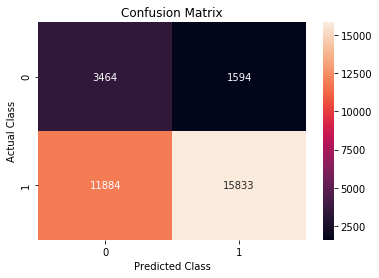

In [44]:
y1_predict = grid.predict(set1_t)
cm1 = confusion_matrix(y_test,y1_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

Word Cloud plot

In [45]:

# condition for filtering out false positive data points
l = (y1_predict != y_test) & (y_test ==0) 
dump = pd.DataFrame(data=l)
# getting only true points
a = dump.loc[dump["project_is_approved"] == True]

# getting index of false positive data points
ilc = a.index.values.tolist()

dummy = []
for index in ilc:
    dummy.append(X_test.loc[index])
    
# false positive data point dataframe    
false_positive = pd.DataFrame(data = dummy)

In [46]:
# getting all text feature on one feature
false_positive["text_data"] = false_positive["essay"] + false_positive["project_title"]

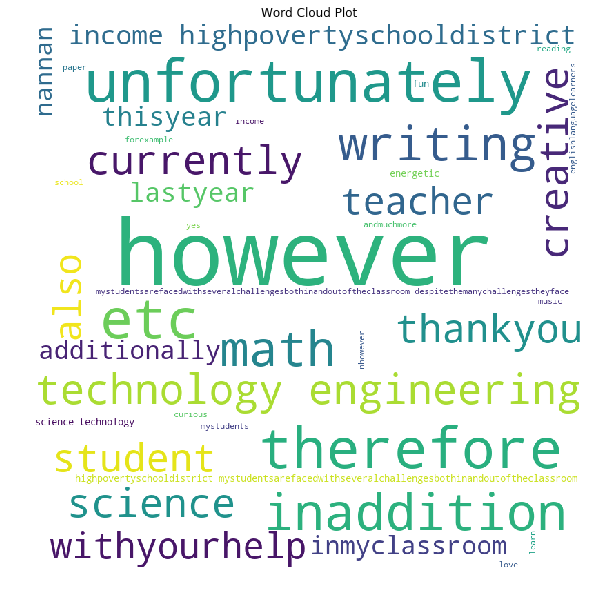

In [47]:
words = " "
for ew in false_positive["text_data"]:
    ew = ew.lower()
    tokens = ew.split()
    for w in tokens:
        words += w
    
# plotting word cloud    
Plot_wordcloud(words)

Box plot of price for false datapoints

Text(0.5, 1.0, 'Box plot of price for false datapoints')

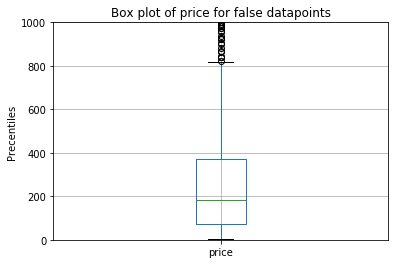

In [48]:
false_positive.boxplot(column = ["price"])
plt.ylim((0,1000))
plt.ylabel("Precentiles")
plt.title("Box plot of price for false datapoints")

pdf for teacher_number_of_previously_posted_projects

Text(0.5, 1.0, 'pdf for teacher_number_of_previously_posted_projects')

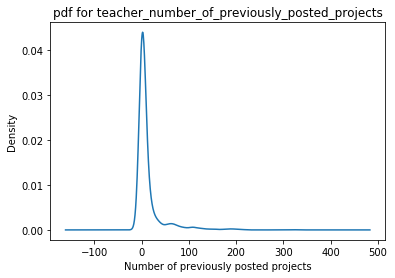

In [49]:
false_positive["teacher_number_of_previously_posted_projects"].plot.kde()
plt.xlabel("Number of previously posted projects")
plt.title("pdf for teacher_number_of_previously_posted_projects")

AUC plotting

In [50]:
# probabilities calcultion
y1_predict_prob = grid.predict_proba(set1_t)[:,1]
y1_predict_prob_train = grid.predict_proba(set1)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)

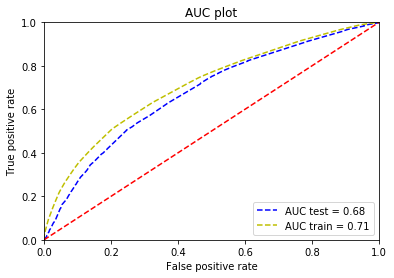

In [51]:
# auc calculation for test data
roc_auc1 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train1 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc1)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train1)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

In [52]:
dt =DecisionTreeClassifier(max_depth=3,min_samples_split=500)

In [53]:
dt.fit(set1,y_train)
with open("donor_classifier_set1.txt", "w") as f:
    f = export_graphviz(dt, out_file=f)

## Set2 (TFIDF)

In [54]:
grid.fit(set2,y_train)

print(grid.best_estimator_)
print(grid.best_index_)
print(grid.best_params_)
print(grid.best_score_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
11
{'max_depth': 10, 'min_samples_split': 500}
0.6659399356392348


In [55]:
#converting results to dataframe
df = pd.DataFrame(data = grid.cv_results_)

# getting into list
test_score = df["mean_test_score"].values
train_score = df["mean_train_score"].values
  
print(train_score)
print(test_score )
x = [x for x in range(len(train_score))]

[0.56693703 0.56693703 0.56693703 0.56693703 0.66805973 0.66805973
 0.66780421 0.66727704 0.73351731 0.73214653 0.72225794 0.71182267
 0.95023417 0.93673965 0.88600689 0.84224526 0.97956894 0.96887928
 0.93054695 0.88193812]
[0.5669371  0.5669371  0.5669371  0.5669371  0.65723565 0.65723565
 0.65703892 0.6571672  0.66090037 0.65973762 0.66103507 0.66593994
 0.58398151 0.58450166 0.60125145 0.62070767 0.57236703 0.57336667
 0.59153767 0.60255109]


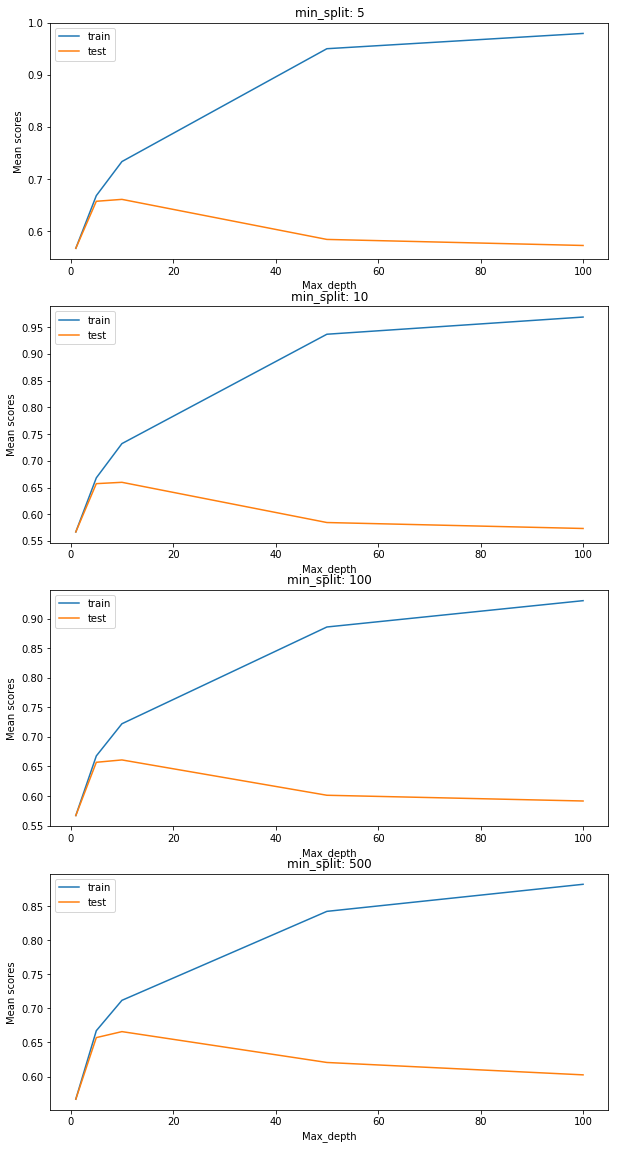

In [56]:
max_depth = [1, 5, 10, 50, 100]
plt.figure(figsize=(10,20))
for i,ms in enumerate(param_grid["min_samples_split"]):
    temp = [x for x in range(i,(16)+i+1,4)]
    train = [train_score[x] for x in temp]
    test = [test_score[x] for x in temp]
    plt.subplot(4,1,i+1)
    plt.title("min_split: "+str(ms))
    plt.plot(max_depth,train )
    plt.plot(max_depth,test)
    plt.legend(["train","test"])
    plt.xlabel("Max_depth")
    plt.ylabel("Mean scores")
    #plt.figure(figsize=(10,20))
    

Confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

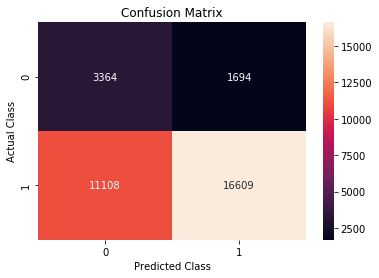

In [57]:
y2_predict = grid.predict(set2_t)
cm2 = confusion_matrix(y_test,y2_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm2, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

Word Cloud

In [58]:
# condition for filtering out false positive data points
l = (y2_predict != y_test) & (y_test ==0) 
dump = pd.DataFrame(data=l)
# getting only true points
a = dump.loc[dump["project_is_approved"] == True]

# getting index of false positive data points
ilc = a.index.values.tolist()

dummy = []
for index in ilc:
    dummy.append(X_test.loc[index])
    
# false positive data point dataframe    
false_positive = pd.DataFrame(data = dummy)

In [59]:
# getting all text feature on one feature
false_positive["text_data"] = false_positive["essay"] + false_positive["project_title"]

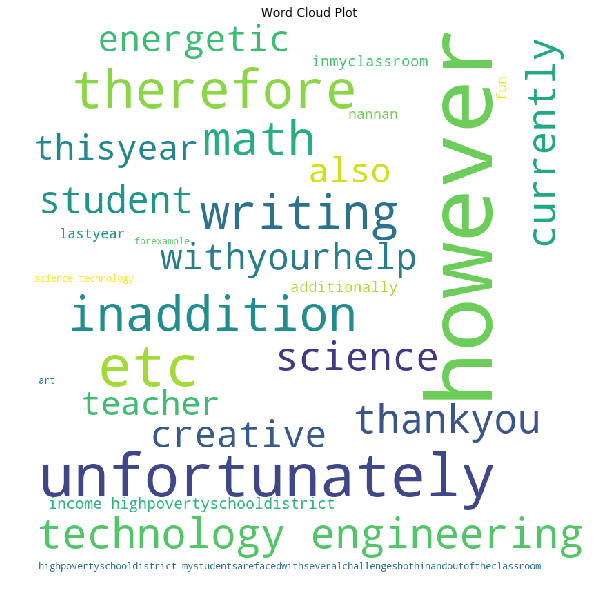

In [60]:
words = " "
for ew in false_positive["text_data"]:
    ew = ew.lower()
    tokens = ew.split()
    for w in tokens:
        words += w
    
# plotting word cloud    
Plot_wordcloud(words)

Box plot of price for false datapoints

Text(0.5, 1.0, 'Box plot of price for false datapoints')

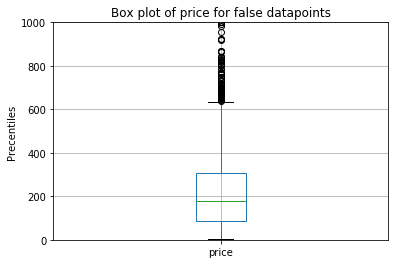

In [61]:
false_positive.boxplot(column = ["price"])
plt.ylim((0,1000))
plt.ylabel("Precentiles")
plt.title("Box plot of price for false datapoints")

pdf for teacher_number_of_previously_posted_projects

Text(0.5, 1.0, 'pdf for teacher_number_of_previously_posted_projects')

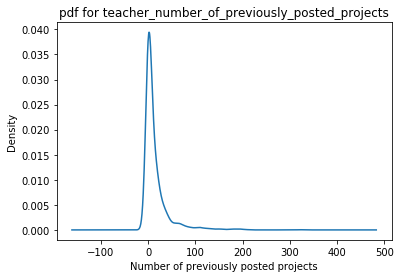

In [62]:
false_positive["teacher_number_of_previously_posted_projects"].plot.kde()
plt.xlabel("Number of previously posted projects")
plt.title("pdf for teacher_number_of_previously_posted_projects")

AUC

In [63]:
# probabilities calcultion
y2_predict_prob = grid.predict_proba(set2_t)[:,1]
y2_predict_prob_train = grid.predict_proba(set2)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y2_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y2_predict_prob_train)


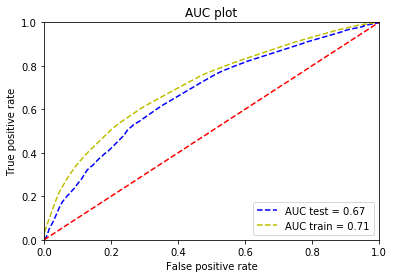

In [64]:
# auc calculation for test data
roc_auc2 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train2 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc2)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train2)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

In [65]:
dt =DecisionTreeClassifier(max_depth=3,min_samples_split=500)
dt.fit(set2,y_train)
with open("donor_classifier_set2.txt", "w") as f:
    f = export_graphviz(dt, out_file=f)

## Set3 (Avg W2V)

In [66]:
grid.fit(set3,y_train)

print(grid.best_estimator_)
print(grid.best_index_)
print(grid.best_params_)
print(grid.best_score_)

#converting results to dataframe
df = pd.DataFrame(data = grid.cv_results_)

# getting into list
test_score = df["mean_test_score"].values
train_score = df["mean_train_score"].values
  
print(train_score)
print(test_score )


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
7
{'max_depth': 5, 'min_samples_split': 500}
0.6601731834425306
[0.56693703 0.56693703 0.56693703 0.56693703 0.68238245 0.68238245
 0.68219065 0.68155258 0.82799592 0.82672219 0.8021493  0.7564052
 0.99899946 0.99797786 0.93087431 0.78766142 0.99995551 0.99949235
 0.9361641  0.78762673]
[0.5669371  0.5669371  0.5669371  0.5669371  0.66001505 0.6600304
 0.6600482  0.66017318 0.62784558 0.62621799 0.63293769 0.65407142
 0.54050481 0.54084546 0.57118371 0.6372408  0.53655424 0.53639439
 0.56436503 0.63743128]


Scores plottng for train/validation

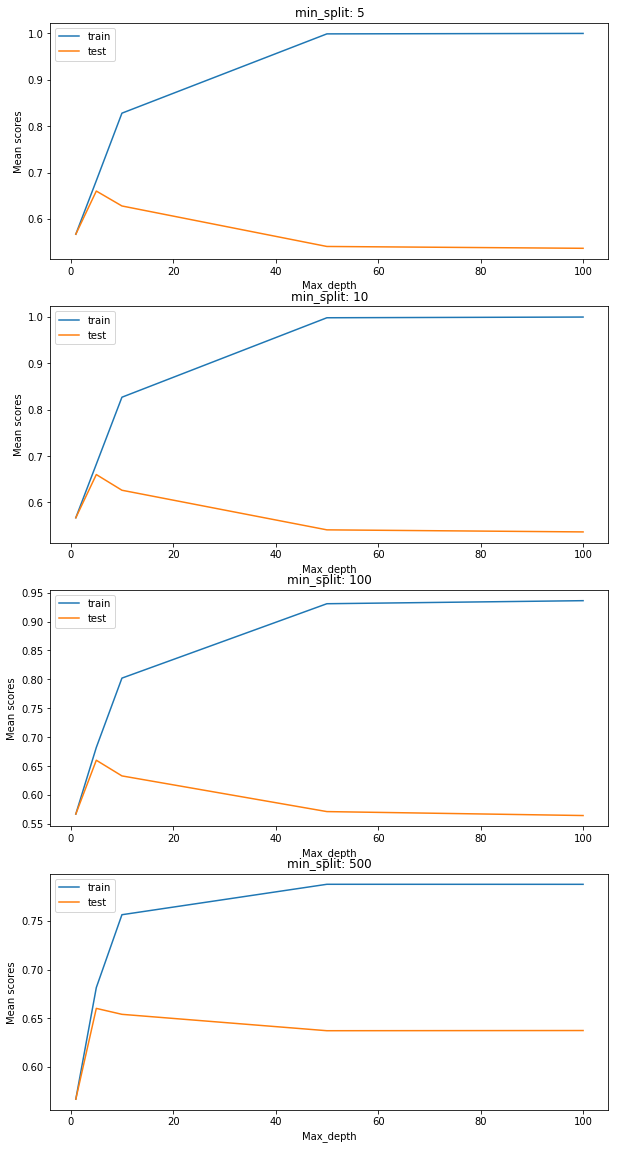

In [67]:
max_depth = [1, 5, 10, 50, 100]
plt.figure(figsize=(10,20))
for i,ms in enumerate(param_grid["min_samples_split"]):
    temp = [x for x in range(i,(16)+i+1,4)]
    train = [train_score[x] for x in temp]
    test = [test_score[x] for x in temp]
    plt.subplot(4,1,i+1)
    plt.title("min_split: "+str(ms))
    plt.plot(max_depth,train )
    plt.plot(max_depth,test)
    plt.legend(["train","test"])
    plt.xlabel("Max_depth")
    plt.ylabel("Mean scores")
    #plt.figure(figsize=(10,20))
    

confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

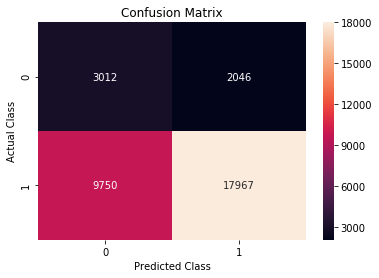

In [68]:
y3_predict = grid.predict(set3_t)
cm3 = confusion_matrix(y_test,y3_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm3, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

Word Cloud

In [69]:
# condition for filtering out false positive data points
l = (y3_predict != y_test) & (y_test ==0) 
dump = pd.DataFrame(data=l)
# getting only true points
a = dump.loc[dump["project_is_approved"] == True]

# getting index of false positive data points
ilc = a.index.values.tolist()

dummy = []
for index in ilc:
    dummy.append(X_test.loc[index])
    
# false positive data point dataframe    
false_positive = pd.DataFrame(data = dummy)


# getting all text feature on one feature
false_positive["text_data"] = false_positive["essay"] + false_positive["project_title"]

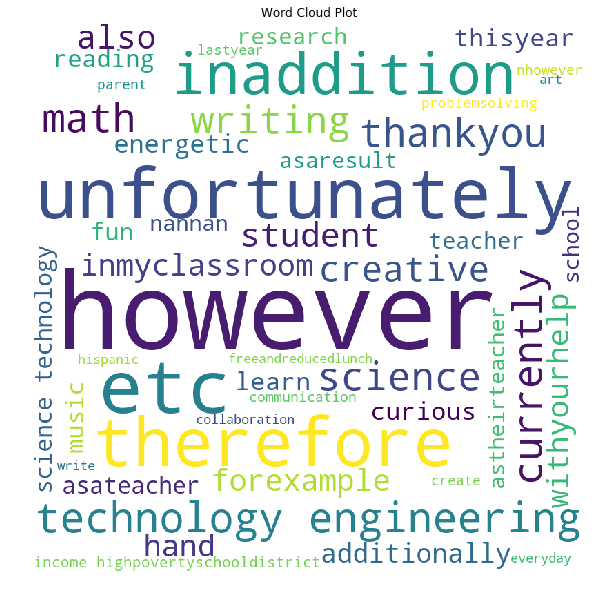

In [70]:
words = " "
for ew in false_positive["text_data"]:
    ew = ew.lower()
    tokens = ew.split()
    for w in tokens:
        words += w
    
# plotting word cloud    
Plot_wordcloud(words)

Boxplot

Text(0.5, 1.0, 'Box plot of price for false datapoints')

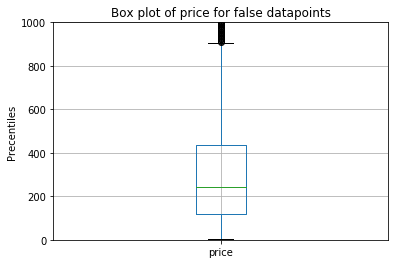

In [71]:
false_positive.boxplot(column = ["price"])
plt.ylim((0,1000))
plt.ylabel("Precentiles")
plt.title("Box plot of price for false datapoints")

KDE

Text(0.5, 1.0, 'pdf for teacher_number_of_previously_posted_projects')

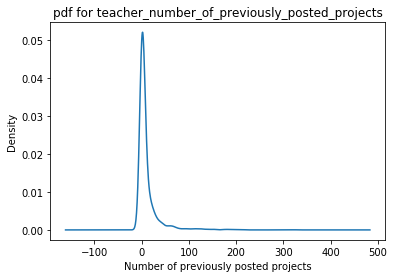

In [72]:
false_positive["teacher_number_of_previously_posted_projects"].plot.kde()
plt.xlabel("Number of previously posted projects")
plt.title("pdf for teacher_number_of_previously_posted_projects")

AUC curve

In [73]:
# probabilities calcultion
y3_predict_prob = grid.predict_proba(set3_t)[:,1]
y3_predict_prob_train = grid.predict_proba(set3)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y3_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y3_predict_prob_train)


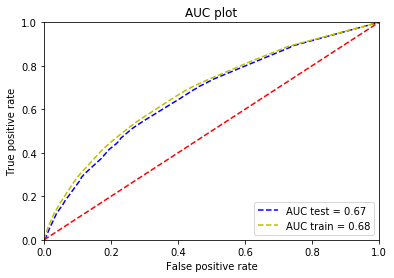

In [74]:
# auc calculation for test data
roc_auc3 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train3 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc3)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train3)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

## Set4 (TFIDF Avg_w2v)

In [75]:
grid.fit(set4,y_train)

#converting results to dataframe
df = pd.DataFrame(data = grid.cv_results_)

# getting into list
test_score = df["mean_test_score"].values
train_score = df["mean_train_score"].values
  
print(train_score)
print(test_score )
x = [x for x in range(len(train_score))]


[0.56693703 0.56693703 0.56693703 0.56693703 0.68220263 0.68220263
 0.68220263 0.68209923 0.82695499 0.82560531 0.79854135 0.7568053
 0.99943971 0.99859908 0.92708653 0.78243853 0.99997351 0.99955165
 0.93033874 0.78238393]
[0.5669371  0.5669371  0.5669371  0.5669371  0.66244859 0.66244859
 0.66244859 0.66259197 0.63290066 0.63155378 0.63624913 0.65238401
 0.53928823 0.54298977 0.57340621 0.63601364 0.53816907 0.53934696
 0.57068871 0.63583987]


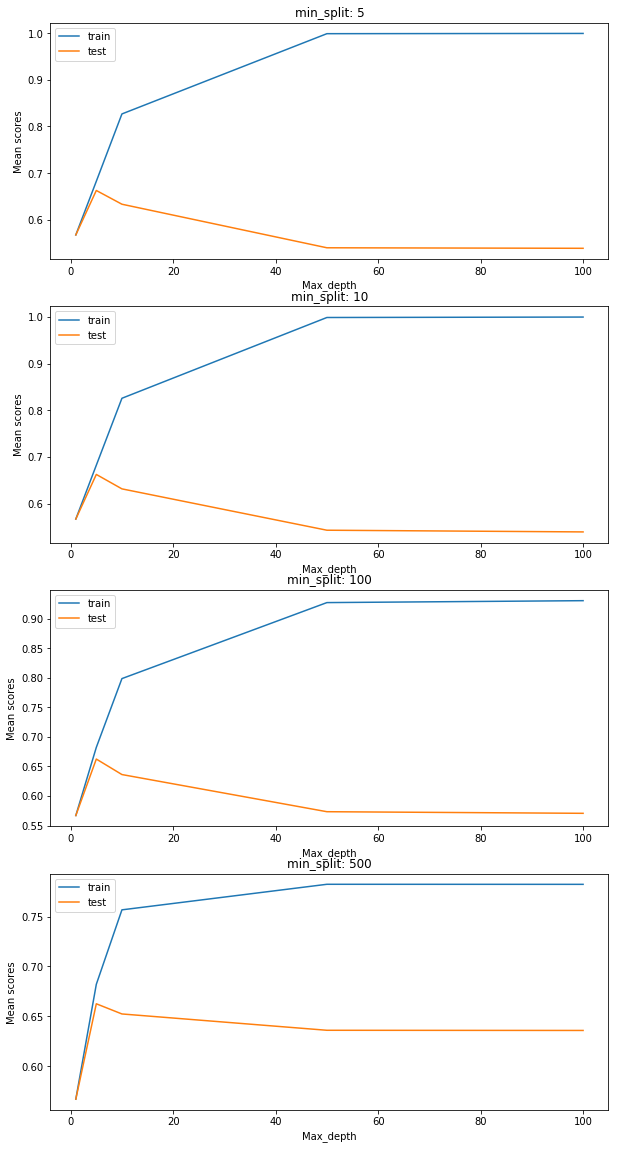

In [76]:
max_depth = [1, 5, 10, 50, 100]
plt.figure(figsize=(10,20))
for i,ms in enumerate(param_grid["min_samples_split"]):
    temp = [x for x in range(i,(16)+i+1,4)]
    train = [train_score[x] for x in temp]
    test = [test_score[x] for x in temp]
    plt.subplot(4,1,i+1)
    plt.title("min_split: "+str(ms))
    plt.plot(max_depth,train )
    plt.plot(max_depth,test)
    plt.legend(["train","test"])
    plt.xlabel("Max_depth")
    plt.ylabel("Mean scores")
    #plt.figure(figsize=(10,20))
    

Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

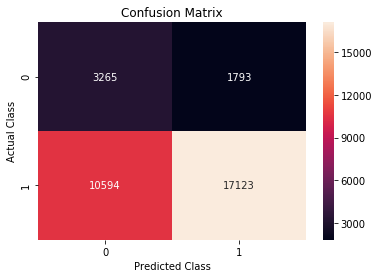

In [77]:
y4_predict = grid.predict(set4_t)
cm1 = confusion_matrix(y_test,y4_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

Word Cloud

In [78]:
# condition for filtering out false positive data points
l = (y4_predict != y_test) & (y_test ==0) 
dump = pd.DataFrame(data=l)
# getting only true points
a = dump.loc[dump["project_is_approved"] == True]

# getting index of false positive data points
ilc = a.index.values.tolist()

dummy = []
for index in ilc:
    dummy.append(X_test.loc[index])
    
# false positive data point dataframe    
false_positive = pd.DataFrame(data = dummy)


# getting all text feature on one feature
false_positive["text_data"] = false_positive["essay"] + false_positive["project_title"]

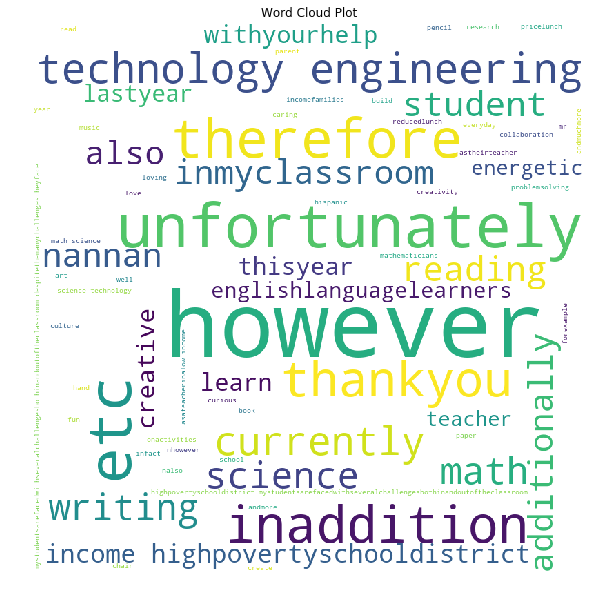

In [79]:
words = " "
for ew in false_positive["text_data"]:
    ew = ew.lower()
    tokens = ew.split()
    for w in tokens:
        words += w
    
# plotting word cloud    
Plot_wordcloud(words)

Boxplot

Text(0.5, 1.0, 'Box plot of price for false datapoints')

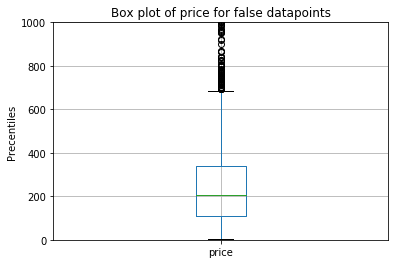

In [80]:
false_positive.boxplot(column = ["price"])
plt.ylim((0,1000))
plt.ylabel("Precentiles")
plt.title("Box plot of price for false datapoints")

KDE

Text(0.5, 1.0, 'pdf for teacher_number_of_previously_posted_projects')

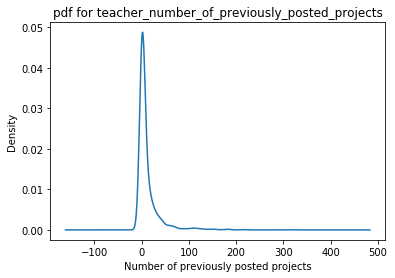

In [81]:
false_positive["teacher_number_of_previously_posted_projects"].plot.kde()
plt.xlabel("Number of previously posted projects")
plt.title("pdf for teacher_number_of_previously_posted_projects")

AUC Curve

In [82]:
# probabilities calcultion
y4_predict_prob = grid.predict_proba(set4_t)[:,1]
y4_predict_prob_train = grid.predict_proba(set4)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y4_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y4_predict_prob_train)


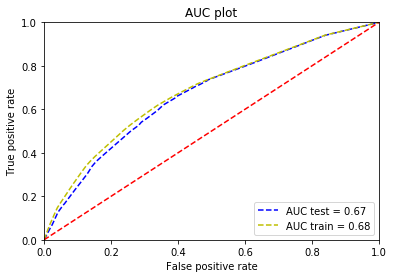

In [83]:
# auc calculation for test data
roc_auc4 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train4 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc4)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train4)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

### Task-2

In [84]:
dt =DecisionTreeClassifier(max_depth = 10, min_samples_split= 500)
dt.fit(set2,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [85]:
top_feature = dt.feature_importances_

In [86]:
df_feature = pd.DataFrame(data=set_feature,columns=["Feature Name"])
df_feature["Feature Value"] = top_feature

In [87]:
print(len(set_feature),len(top_feature))

7945 7945


In [88]:
df_feature = df_feature.sort_values(by = ["Feature Value"],ascending=False)
df_feature.head()

Feature Name  Feature Value
7942            price       0.261452
7943         quantity       0.177677
7944           number       0.112230
4418  these materials       0.070706
38           Literacy       0.033001

In [89]:
# selecting top 5k features
df_feature = df_feature[:5000]

In [90]:
# getting the list of indices of top  features
index_list = df_feature.index.tolist()

In [91]:
# converting to csr to access elements
s = set2.tocsr()
s_t = set2_t.tocsr()
print(s.shape)
print(s_t.shape)

(76473, 7945)
(32775, 7945)


In [92]:
# Extracting specific columns in numpy array
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array
s = s[:,index_list]
s_t = s_t[:,index_list]
print(s.shape)
print(s_t.shape)

(76473, 5000)
(32775, 5000)


### Set-5

In [93]:
grid.fit(s,y_train)

#converting results to dataframe
df = pd.DataFrame(data = grid.cv_results_)

# getting into list
test_score = df["mean_test_score"].values
train_score = df["mean_train_score"].values
  
print(train_score)
print(test_score )
x = [x for x in range(len(train_score))]


[0.56693703 0.56693703 0.56693703 0.56693703 0.66735511 0.66734742
 0.66720959 0.66675191 0.72784575 0.72635176 0.71950575 0.71008743
 0.94453443 0.93131629 0.88299778 0.83716345 0.98040112 0.9682588
 0.92744884 0.87845045]
[0.5669371  0.5669371  0.5669371  0.5669371  0.65762677 0.65772865
 0.65761569 0.6576396  0.66397721 0.66316059 0.66461115 0.66815694
 0.58680676 0.58546198 0.60418039 0.62106944 0.56258852 0.56765982
 0.58588737 0.60139381]


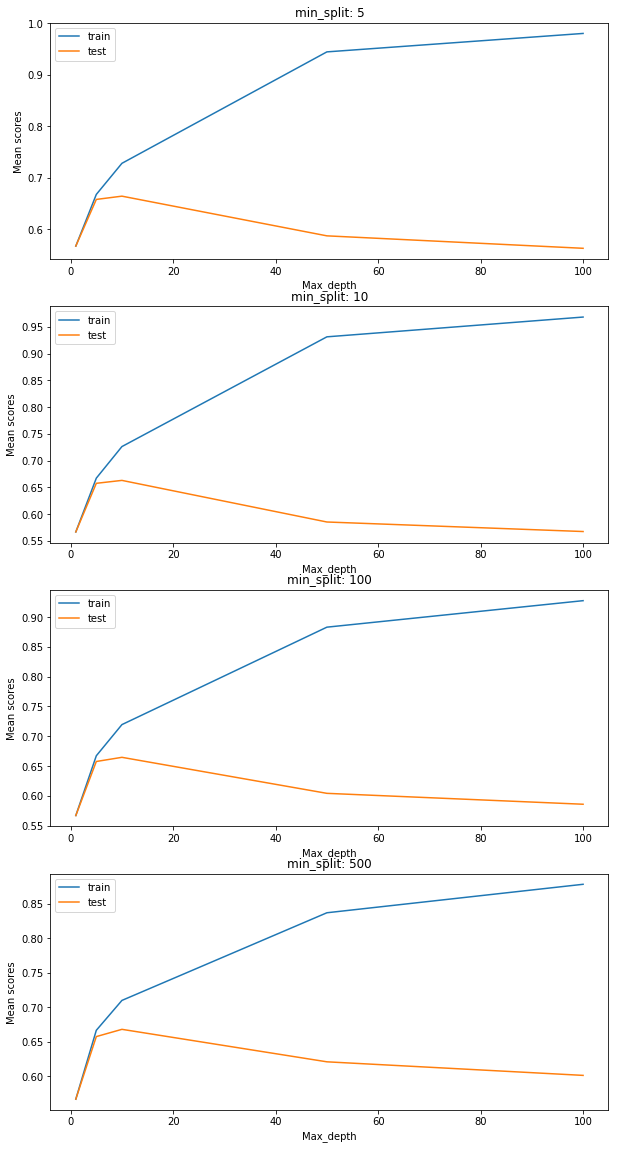

In [94]:
max_depth = [1, 5, 10, 50, 100]
plt.figure(figsize=(10,20))
for i,ms in enumerate(param_grid["min_samples_split"]):
    temp = [x for x in range(i,(16)+i+1,4)]
    train = [train_score[x] for x in temp]
    test = [test_score[x] for x in temp]
    plt.subplot(4,1,i+1)
    plt.title("min_split: "+str(ms))
    plt.plot(max_depth,train )
    plt.plot(max_depth,test)
    plt.legend(["train","test"])
    plt.xlabel("Max_depth")
    plt.ylabel("Mean scores")
    #plt.figure(figsize=(10,20))
    

Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

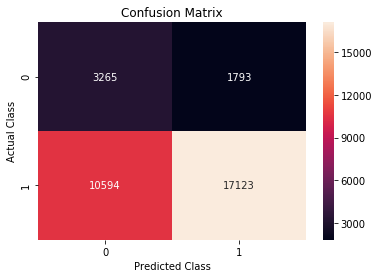

In [95]:
y5_predict = grid.predict(s_t)
cm5 = confusion_matrix(y_test,y5_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

Word Cloud

In [96]:
# condition for filtering out false positive data points
l = (y5_predict != y_test) & (y_test ==0) 
dump = pd.DataFrame(data=l)
# getting only true points
a = dump.loc[dump["project_is_approved"] == True]

# getting index of false positive data points
ilc = a.index.values.tolist()

dummy = []
for index in ilc:
    dummy.append(X_test.loc[index])
    
# false positive data point dataframe    
false_positive = pd.DataFrame(data = dummy)


# getting all text feature on one feature
false_positive["text_data"] = false_positive["essay"] + false_positive["project_title"]

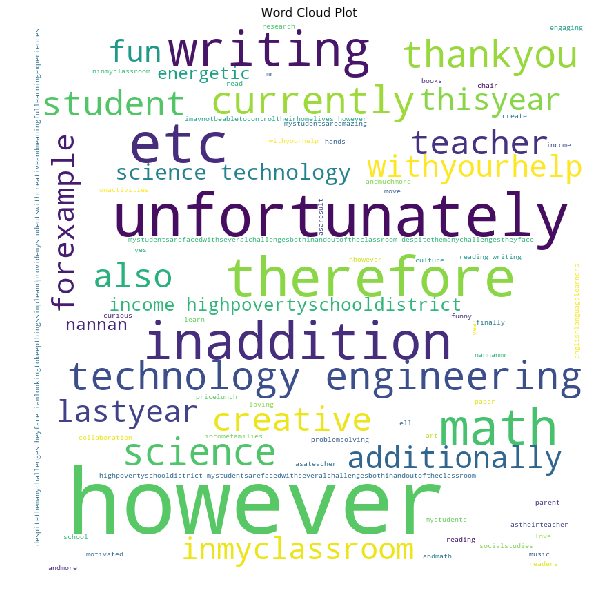

In [97]:
words = " "
for ew in false_positive["text_data"]:
    ew = ew.lower()
    tokens = ew.split()
    for w in tokens:
        words += w
    
# plotting word cloud    
Plot_wordcloud(words)

Box Plot

Text(0.5, 1.0, 'Box plot of price for false datapoints')

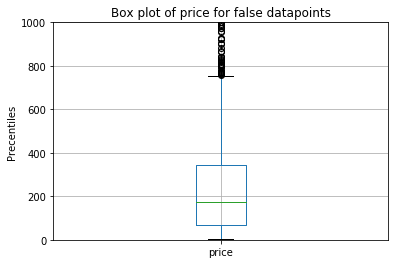

In [98]:
false_positive.boxplot(column = ["price"])
plt.ylim((0,1000))
plt.ylabel("Precentiles")
plt.title("Box plot of price for false datapoints")

KDE

Text(0.5, 1.0, 'pdf for teacher_number_of_previously_posted_projects')

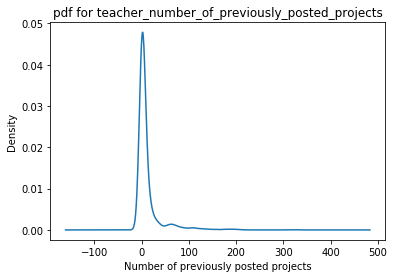

In [99]:
false_positive["teacher_number_of_previously_posted_projects"].plot.kde()
plt.xlabel("Number of previously posted projects")
plt.title("pdf for teacher_number_of_previously_posted_projects")

AUC CURVE

In [100]:
# probabilities calcultion
y5_predict_prob = grid.predict_proba(s_t)[:,1]
y5_predict_prob_train = grid.predict_proba(s)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y5_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y5_predict_prob_train)


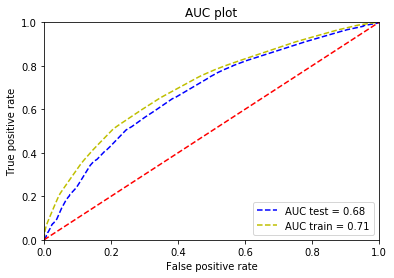

In [101]:
# auc calculation for test data
roc_auc5 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train5 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc5)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train5)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

### Observation
1. Best Result found in case of TFIDF W2V
2. Best accuracy was found is 0.712 in case of TFIDF
3. Model performed worst in case of AVG-W2V

### Summary

In [102]:
from prettytable import PrettyTable
summary = PrettyTable()

In [103]:
summary.field_names = ["Set", "Vectorizer", "Model", "Hyperparameter","Test","Train"]

In [104]:
summary.add_row(["set1","BOW","DT","Depth = 10,min_samples = 500","%0.3f"%roc_auc1,"%0.3f"%roc_auc_train1])
summary.add_row(["set2","TFIDF","DT","Depth = 10,min_samples = 500","%0.3f"%roc_auc2,"%0.3f"%roc_auc_train2])
summary.add_row(["set1","Avg-W2v","DT","Depth = 10,min_samples = 500","%0.3f"%roc_auc3,"%0.3f"%roc_auc_train3])
summary.add_row(["set2","TFIDF W2V","DT","Depth = 10,min_samples = 500","%0.3f"%roc_auc4,"%0.3f"%roc_auc_train4])
summary.add_row(["set1","TFIDF top 5k","DT","Depth = 10,min_samples = 500","%0.3f"%roc_auc5,"%0.3f"%roc_auc_train5])


In [105]:
print(summary)

+------+--------------+-------+------------------------------+-------+-------+
| Set  |  Vectorizer  | Model |        Hyperparameter        |  Test | Train |
+------+--------------+-------+------------------------------+-------+-------+
| set1 |     BOW      |   DT  | Depth = 10,min_samples = 500 | 0.676 | 0.709 |
| set2 |    TFIDF     |   DT  | Depth = 10,min_samples = 500 | 0.675 | 0.712 |
| set1 |   Avg-W2v    |   DT  | Depth = 10,min_samples = 500 | 0.667 | 0.681 |
| set2 |  TFIDF W2V   |   DT  | Depth = 10,min_samples = 500 | 0.668 | 0.681 |
| set1 | TFIDF top 5k |   DT  | Depth = 10,min_samples = 500 | 0.677 | 0.708 |
+------+--------------+-------+------------------------------+-------+-------+
